**List 7** - Algorithms and Data Structures 2021/22, WUST - F13

*Author:* Mateusz Machaj, 262288

*Date:* 24.01.2022

# Import

There are the imports I use. `graphviz` have to be installed both in Python (`pip install graphviz`) and on OS (`winget install graphviz` for Windows), with added executable file to the *PATH*.

In [1]:
from __future__ import annotations

import queue
import sys
import warnings
from typing import Any, List, Optional, Set, Tuple, Union

# grapviz have to be installed in Program Files and added to the PATH
import graphviz

The following lines are to change the warning message format and skip the traceback info.

In [2]:
def no_traceback_warning(
    message, category, filename=None, lineno=None, file=None, line=None
):
    return "{cat}: {mess}\n".format(cat=category.__name__, mess=message)


warnings.formatwarning = no_traceback_warning

-----------------------

# Task 1

_**Graph class implementation**_

-----------------------

The basic graph with the methods from the lecture [[1]](#ref1) is consists of the nodes. These classes are partially copied from the referenced lecture. However, there are some changes and I have added node and edge deletion. There is also an option to create **directed** or **undirected** graph.

In the second one we cannot connect one node with itself (by edge), because that is the rule from definition. The first option allows it though.

In my implementation adding a node with the key that already exist does not affect the structure. Nothing changes. Similarly, adding the existing edge only updates its weight. 

## Node

I begin with creating the node class used later in the graph. It will contain also the features required for searching algorithms in the next tasks.

I do not use unncessary `get` and `set` methods for attributes, because the code is written with respect to Python conventions.

In [66]:
class Node:
    def __init__(self, key: Union[int, float, str, chr, bool]):
        self.key = key
        self.neighbors = dict()
        self.neighbor_for = set()

        self.dist = sys.maxsize  # "infinity"
        self.color = "w"
        self.pred = None
        self.disc = 0  #########################################################
        self.fin = 0

    def reset(self):
        self.dist = sys.maxsize
        self.color = "w"
        self.pred = None
        self.disc = 0  #########################################################
        self.fin = 0

    def add_neighbor(self, neighbor: Node, weight: float = 0):
        self.neighbors[neighbor] = weight
        neighbor.neighbor_for.add(self)

    def rem_neighbor(self, neighbor: Node) -> Optional[Node]:
        popped = self.neighbors.pop(neighbor, None)
        if popped is None:
            return False
        else:
            neighbor.neighbor_for.remove(self)
            return True

    def get_weight(self, neighbor: Node) -> float:
        try:
            weight = self.neighbors[neighbor]
        except KeyError as key:
            raise Exception(
                'Node "{key}" is not a neighbor of this node.'.format(key=key)
            )
        else:
            return weight

    def __str__(self):
        return (
            str(self.key)
            + ";color "
            + self.color
            + ";discovery "
            + str(self.disc)
            + ";finish "
            + str(self.fin)
            + ";distance "
            + str(self.dist)
            + ";predecessor \n\t["
            + str(self.pred)
            + "]\n"
        )

## Graph

The following class is only the basic graph version supporting:

- **directed** and **undirected** graph versions;
- **node** and **edge** addition - as one element or by a list,
- **node** and **edge** deletion - as one element or by a list,
- getting **nodes** and **edges** listed,
- getting **node's** object by key,
- `in` operator for node keys,
- checking the size (number of nodes and number of edges)
- iteration.

Each edge is weighted (in case the weight is not given it defaults to 0). Nodes can have alphaumeric or string keys but do not contain additional value data. 

In [87]:
class GraphBasic:
    def __init__(self, directed: bool = True):
        self.nodes = dict()
        self.node_count = 0
        self.edge_count = 0
        self.directed = directed
        
        self.time = 0

    def __contains__(self, key: Any) -> bool:
        return key in self.nodes

    def get_node(self, key: float) -> Optional[Node]:
        try:
            des_node = self.nodes[key]
        except KeyError:
            return None
        else:
            return des_node

    def get_nodes(self) -> Set[Any]:
        return set(self.nodes.keys())

    def get_nodes_obj(self) -> Set[Node]:
        return set(self.nodes.values())

    def get_edges(
        self,
    ) -> Union[Set[Tuple[Any, Any, float]], Set[Tuple[Set[Any, Any], float]]]:
        edge_set = set()

        def edge_tup_repr(from_key, to_info):
            if self.directed:
                return (from_key, to_info[0].key), to_info[1]
            else:
                return frozenset({from_key, to_info[0].key}), to_info[1]

        for key, node in self.nodes.items():
            edges_pr = map(
                lambda to_info: edge_tup_repr(key, to_info), node.neighbors.items()
            )
            new_edges = set(edges_pr)
            edge_set.update(new_edges)

        return edge_set

    def add_node(self, key: Union[int, float, str, chr, bool]) -> Node:
        if key not in self:
            new_node = Node(key)
            self.nodes[key] = new_node
            self.node_count += 1
            return new_node
        else:
            warnings.warn(
                'Key "{key}" was already in the graph. Foregoing neighbors are keeped.'.format(
                    key=key
                ),
                category=DeprecationWarning,
            )
            return self.nodes[key]

    def add_edge(
        self,
        from_key: Union[int, float, str, chr, bool],
        to_key: Union[int, float, str, chr, bool],
        weight: float = 0,
    ):
        if not self.directed and from_key == to_key:
            raise ValueError(
                'Creating "{key}"-"{key}" edge failed. Undirected graph cannot contain self connecting nodes.'.format(
                    key=from_key
                )
            )

        for key in [from_key, to_key]:
            if key not in self:
                self.add_node(key)

        from_node = self.nodes[from_key]
        to_node = self.nodes[to_key]
        if not (to_node in from_node.neighbors):
            self.edge_count += 1
        from_node.add_neighbor(to_node, weight)

        if not self.directed:
            to_node.add_neighbor(from_node, weight)

    def del_node(self, key: Union[int, float, str, chr, bool]):
        curr_node = self.get_node(key)
        if curr_node is None:
            warnings.warn(
                'Key "{key}" is not in the graph. This node was not deleted.'.format(
                    key=key
                ),
                category=DeprecationWarning,
            )
        else:
            con_nodes = curr_node.neighbor_for.copy()
            for node in con_nodes:
                node.rem_neighbor(curr_node)
            self.nodes.pop(key)
            self.node_count -= 1

    def del_edge(
        self,
        from_key: Union[int, float, str, chr, bool],
        to_key: Union[int, float, str, chr, bool],
    ):
        nodes_exist = True
        edge_exist = True
        for key in [from_key, to_key]:
            if key not in self:
                nodes_exist = False
                warnings.warn(
                    'Key "{key}" is not in the graph.'.format(key=key),
                    category=DeprecationWarning,
                )
        if nodes_exist:
            from_node = self.nodes[from_key]
            to_node = self.nodes[to_key]
            success = from_node.rem_neighbor(to_node)
            self.edge_count -= 1
            if not self.directed:
                to_node.rem_neighbor(from_node)
            if success:
                edge_exist = False
        if not nodes_exist or not edge_exist:

            def relat_symb():
                return "->" if self.directed else "<->"

            warnings.warn(
                'Nonexistent "{fr}"{rel_s}"{to}" edge was not deleted.'.format(
                    fr=from_key, to=to_key, rel_s=relat_symb()
                ),
                category=DeprecationWarning,
            )

    def add_nodes(self, key_list: List[Union[int, float, str, chr, bool]]):
        for key in key_list:
            self.add_node(key)

    def add_edges(
        self,
        edge_list: List[
            Tuple[
                Union[int, float, str, chr, bool],
                Union[int, float, str, chr, bool],
                float,
            ]
        ],
    ):
        for edge in edge_list:
            self.add_edge(*edge)

    def del_edges(
        self,
        edge_list: List[
            Tuple[
                Union[int, float, str, chr, bool],
                Union[int, float, str, chr, bool],
            ]
        ],
    ):
        for edge in edge_list:
            self.del_edge(*edge)

    def del_nodes(self, key_list: List[Union[int, float, str, chr, bool]]):
        for key in key_list:
            self.del_node(key)

    def size(self):
        return {"nodes": self.node_count, "edges": self.edge_count}

    def __iter__(self):
        return iter(self.nodes.values())

## Presentation

All the features are shown in the next task, because of visualization available.

-----------------------

# Task 2

_**Graph visualisation in "dot"**_

-----------------------

The only thing there is the visualization method added. I use `graphviz` library and `dot` language as it was given.

## Enhanced graph class 

In [88]:
class GraphVis(GraphBasic):
    def visualize(self) -> Union[graphviz.graphs.Digraph, graphviz.graphs.Graph]:
        if self.directed:
            dot = graphviz.Digraph()
        else:
            dot = graphviz.Graph()
        dot.attr("node", style="filled", fillcolor="lightblue2")
        for key in self.get_nodes():
            dot.node(str(key))
        for node_keys, weight in self.get_edges():
            from_node, to_node = list(node_keys)
            edge_data = list(map(str, [from_node, to_node, weight]))
            dot.edge(*edge_data)

        return dot

-----------------------

# Task 3

_**Graph searching methods - BFS and DFS**_

-----------------------

In [129]:
class Graph(GraphVis):
    def _reset_hdata(self):
        self.time = 0
        for node in self.get_nodes_obj():
            node.reset()

    def search_bfs(self, start_key: key):
        start_node = self.get_node(start_key)
        if start_key is None:
            raise ValueError('Key "{key}" is not in the graph.'.format(key=start_key))

        start_node.dist = 0
        bfs_queue = queue.SimpleQueue()
        bfs_queue.put_nowait(start_node)
        stack = []
        
        while not bfs_queue.empty():
            curr_node = bfs_queue.get_nowait()
            # white_neihgs = 0
            for neigh_node in curr_node.neighbors:
                if neigh_node.color == "w":
                    neigh_node.color = "g"
                    neigh_node.dist = curr_node.dist + 1
                    neigh_node.pred = curr_node
                    bfs_queue.put_nowait(neigh_node)
                    # white_neihgs += 1
            curr_node.color = "b"
            # if white_neihgs:
            #     stack.append(curr_node)
            # else:
            #     curr_node.fin = self.time
            #     self.time += 1
            # white_neihgs = 0
            

    def whites(self):
        white_nodes = []
        for node in self.get_nodes_obj():
            if node.color == "w":
                white_nodes.append(node)
        return white_nodes

    # def topo(self):
    #     visit_times = dict()
    #     while True:
    #         white_nodes = self.whites()
    #         if not white_nodes:
    #             break
    #         self.search_bfs(white_nodes[0].key)
    #     for node in self.get_nodes_obj():
    #         visit_times[node.fin] = node.key
    #     return sorted(visit_times.items(), reverse=True)

In [130]:
a = Graph()
a.add_edges([("a", "c", 3), ("a", "d", 5), ("b", "a", 1)])
a.add_edges([("c", "e"), ("e", 1.4523523523, 4), ("e", "g", 5)])

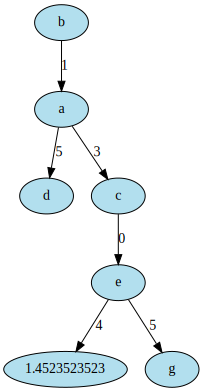

In [131]:
a.visualize()

In [132]:
a.topo()

[(4, 'b'), (3, 'c'), (2, 1.4523523523), (1, 'd'), (0, 'a')]

-----------------------

# Task 4

_**DFS features modification - topological sorting**_

-----------------------

-----------------------

# Task 5

_**Optimal paths between the nodes**_

-----------------------

-----------------------

# Task 6

_**"Missionaries and cannibals" problem**_

-----------------------

-----------------------

# Task 7

_**"Water in buckets" problem**_

-----------------------

-----------------------

# References

-----------------------

<a id="ref1">[1]</a> J. Szwabiński, *Wykład 10 - Grafy i podstawowe algorytmy grafowe*,  *Algorytmy i struktury danych*, p. 2-16. [accessed: 24.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/10.pdf.

-----------------------